# Data drift detection

In the context of **machine learning, data drift** refers to a change in the statistical properties of the input data over time compared to the data on which the model was originally trained. This can cause the model’s performance to deteriorate, since it may no longer generalize well to new, unseen data.

There are several types of data drift, including:

- **Covariate Drift (Feature Drift)**: The distribution of the input features changes, but the relationship between features and target remains the same. Example: A model was trained when a feature had values in a certain range. Over time, if that feature shifts to a different range, covariate drift occurs.

- **Prior Probability Drift (Label Drift)**: The distribution of the target variable changes. Example: A model trained to predict energy consumption during a season may fail if seasonal patterns change due to external factors.

- **Concept Drift**: The relationship between input features and the target variable changes. Example: A model predicting energy consumption from weather data might fail if new technologies or behaviors alter how weather affects energy usage.

Detecting and addressing data drift is crucial for maintaining the model performance in production. Common strategies include:

- **Monitoring input data** during the prediction phase.

- **Monitoring model performance** (accuracy, precision, recall, etc.) over time.

- **Periodically retraining the model** with new data to adapt to changes.

## Drift detection with Skforecast

Skforecast provides two classes to detect data drift: [`PopulationDriftDetector`](../api/drift_detection.html#skforecast.drift_detection.drift_detection.PopulationDriftDetector) and [`RangeDriftDetector`](../api/drift_detection.html#skforecast.drift_detection.drift_detection.RangeDriftDetector). The former one is focused on detecting changes at population level, therefore it is suitable for dectecting when forecasting models need to be retrained. The latter one is focused on detecting changes at single observation level, therefore it is suitable for checking the input data before during the prediction phase.

The follwing sections provide information and examples on how to use each of these classes.

## Population drift: feature drift and label drift

`skforecast` provides the class [`PopulationDriftDetector`](../api/drift_detection.html#skforecast.drift_detection.drift_detection.PopulationDriftDetector) to detect **feature drift** and **label drift** in time series data.

The detector evaluates whether the distribution of the input data (target series and exogenous variables) remains consistent with the distribution of the data used to train the forecasting model.  
Because it operates on samples of data, it can identify when the characteristics of new data differ significantly from the training data, indicating that the model may need to be retrained.

The API follows the same design principles as the forecasters:

- The data used to fit a forecaster can also be used to fit the [`PopulationDriftDetector`](../api/drift_detection.html#skforecast.drift_detection.drift_detection.PopulationDriftDetector).

- When new historical data becomes available (i.e., multiple new observations), the `predict` method can be used to check for drift. If drift is detected, users should analyze its cause and consider retraining the forecasting model.


<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

<p>
  For detailed information about how calulations are performed visit section <a href="https://skforecast.org/latest/user_guides/drift-detection#Deep-dive-in-population-drift-detection" target="_blank" rel="noopener noreferrer">Population drift detection in a single series</a> of the User Guide.
</p>

</div>

In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent.parent)
print(path)
sys.path.insert(1, path)

import skforecast
print(skforecast.__version__)

/home/joaquin/Documents/GitHub/skforecast
0.18.0


In [2]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme
from skforecast.drift_detection import PopulationDriftDetector

In [15]:
data = pd.read_parquet('bike_sharing.parquet')
data

,holiday,workingday,weather,temp,atemp,hum,windspeed,users,month,hour,weekday
date_time,,,,,,,,,,,
2011-01-01 00:00:00,0.0,0.0,clear,9.84,14.395,81.0,0.0000,16.0,1,0,5
2011-01-01 01:00:00,0.0,0.0,clear,9.02,13.635,80.0,0.0000,40.0,1,1,5
2011-01-01 02:00:00,0.0,0.0,clear,9.02,13.635,80.0,0.0000,32.0,1,2,5
2011-01-01 03:00:00,0.0,0.0,clear,9.84,14.395,75.0,0.0000,13.0,1,3,5
2011-01-01 04:00:00,0.0,0.0,clear,9.84,14.395,75.0,0.0000,1.0,1,4,5
...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,0.0,1.0,mist,10.66,12.880,60.0,11.0014,119.0,12,19,0
2012-12-31 20:00:00,0.0,1.0,mist,10.66,12.880,60.0,11.0014,89.0,12,20,0
2012-12-31 21:00:00,0.0,1.0,clear,10.66,12.880,60.0,11.0014,90.0,12,21,0


In [44]:
# Data
# ==============================================================================
#data = fetch_dataset('bike_sharing', verbose=False)
data = pd.read_parquet('bike_sharing.parquet')
data = data[['temp']]
data_train = data.iloc[: 9000].copy()
data_new  = data.iloc[9000:].copy()

Data has been split into training and new data to mimic a real case scenario where new historical data is available after the model has been trained.

The new data partition is then modify to simulate the scenario where a drift occurs:

- Observations in July are increased by 20 degrees.
- Observations in October are set to a constat value of the mean of the original data. This means that the value is not unusual given the original data distribution, but it is unusual its constant value for a whole month.
- Observations in December are decreased by 10 degrees.

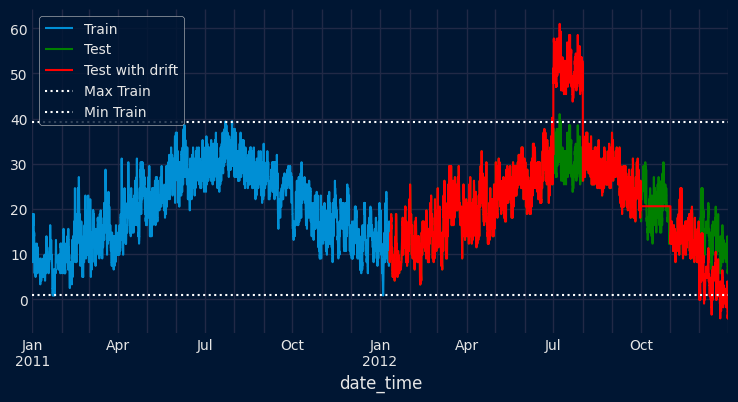

In [45]:
# Inject changes in the distribution
# ==============================================================================
data_new_drift = data_new.copy()

# Sum +20 to observations of july 2012
data_new_drift.loc['2012-07-01 00:00:00':'2012-07-31 23:00:00', 'temp'] = (
    data_new_drift.loc['2012-07-01 00:00:00':'2012-07-31 23:00:00', 'temp'] + 20
)

# Constant mean value in October 2012
data_new_drift.loc['2012-10-01 00:00:00':'2012-10-31 23:00:00', 'temp'] = (
    data_new_drift.loc['2012-10-01 00:00:00':'2012-10-31 23:00:00', 'temp'].mean()
)

# Substract -10 to december 2012
data_new_drift.loc['2012-12-01 00:00:00':'2012-12-31 23:00:00', 'temp'] = (
    data_new_drift.loc['2012-12-01 00:00:00':'2012-12-31 23:00:00', 'temp'] - 10
)

# Plot
# ==============================================================================
set_dark_theme()
fig, ax = plt.subplots(figsize=(8, 4))
data_train.loc[:, 'temp'].plot(ax=ax, label='Train')
data_new.loc[:, 'temp'].plot(ax=ax, label='Test', color='green')
data_new_drift.loc[:, 'temp'].plot(ax=ax, label='Test with drift', color='red')
ax.axhline(data_train['temp'].max(), color='white', linestyle=':', label='Max Train')
ax.axhline(data_train['temp'].min(), color='white', linestyle=':', label='Min Train')
ax.legend();

In [46]:
# Fit detector using the training data
# ==============================================================================
detector = PopulationDriftDetector(
    chunk_size = 'ME',            
    threshold  = 0.95
)
detector.fit(data_train)

Once the detector have been fitted, It can be used to evaluate new data. The method `predict` returns two dataframes: the first one contains detail information about the statistics, threholds and drift for each chunk. The second one is a summary table with the number and percentage of chunks where drift have been detected.

In [47]:
drif_results, drift_summary = detector.predict(data_new_drift)
drif_results

,chunk,chunk_start,chunk_end,feature,ks_statistic,threshold_ks,chi2_statistic,threshold_chi2,jensen_shannon,threshold_js,reference_range,is_out_of_range,drift_ks_statistic,drift_chi2_statistic,drift_js,drift_detected
0,0,2012-01-11,2012-01-31 23:00:00,temp,0.490175,0.682966,NaN,NaN,0.546958,0.689223,"(0.8200000000000001, 39.36)",False,False,False,False,False
1,1,2012-02-01,2012-02-29 23:00:00,temp,0.477663,0.682966,NaN,NaN,0.523748,0.689223,"(0.8200000000000001, 39.36)",False,False,False,False,False
2,2,2012-03-01,2012-03-31 23:00:00,temp,0.232412,0.682966,NaN,NaN,0.373938,0.689223,"(0.8200000000000001, 39.36)",False,False,False,False,False
3,3,2012-04-01,2012-04-30 23:00:00,temp,0.217000,0.682966,NaN,NaN,0.455947,0.689223,"(0.8200000000000001, 39.36)",False,False,False,False,False
4,4,2012-05-01,2012-05-31 23:00:00,temp,0.443082,0.682966,NaN,NaN,0.539446,0.689223,"(0.8200000000000001, 39.36)",False,False,False,False,False
5,5,2012-06-01,2012-06-30 23:00:00,temp,0.504222,0.682966,NaN,NaN,0.551198,0.689223,"(0.8200000000000001, 39.36)",True,False,False,False,True
6,6,2012-07-01,2012-07-31 23:00:00,temp,1.000000,0.682966,NaN,NaN,1.000000,0.689223,"(0.8200000000000001, 39.36)",True,True,False,True,True
7,7,2012-08-01,2012-08-31 23:00:00,temp,0.637269,0.682966,NaN,NaN,0.652528,0.689223,"(0.8200000000000001, 39.36)",False,False,False,False,False
8,8,2012-09-01,2012-09-30 23:00:00,temp,0.446389,0.682966,NaN,NaN,0.518331,0.689223,"(0.8200000000000001, 39.36)",False,False,False,False,False
9,9,2012-10-01,2012-10-31 23:00:00,temp,0.537556,0.682966,NaN,NaN,0.863793,0.689223,"(0.8200000000000001, 39.36)",False,False,False,True,True


In [48]:
drift_summary

,feature,n_chunks_with_drift,pct_chunks_with_drift
0,temp,4,33.333333


<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

<p>
<code>PopulationDriftDetector</code> can be used with multiple series simultaniusly. For that, the input data must be a dataframe with MultiIndex where the first level is the series id and the second level the temporal index.
</p>

</div>

## Drift detection during prediction

Skforecast provides the class [`RangeDriftDetector`](../api/drift_detection.html#skforecast.drift_detection.drift_detection.RangeDriftDetector) to detect **covariate drift** in both **single** and **multiple** time series, as well as in **exogenous variables**. 

The detector checks whether the input data (lags and exogenous variables) used to **predict new values** fall within the range of the data used to **train the model**. 

Its API follows the same design as the forecasters: 

+ The data used to **train a forecaster** can also be used to **fit the** [`RangeDriftDetector`](../api/drift_detection.html#skforecast.drift_detection.drift_detection.RangeDriftDetector).

+ The data passed for **prediction** can be used to **check for drift**.

In [8]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
from sklearn.ensemble import HistGradientBoostingRegressor
from skforecast.datasets import fetch_dataset
from skforecast.recursive import ForecasterRecursive
from skforecast.drift_detection import RangeDriftDetector

### Detecting out-of-range values in a single series

The `RangeDriftDetector` checks whether the values of a time series remain consistent with the data seen during training.

+ For **numeric variables**, it verifies that each new value falls **within the minimum and maximum range** of the training data. Values outside this range are flagged as potential drift.

+ For **categorical variables**, it checks whether each new category was **observed during training**. Unseen categories are flagged as potential drift.

This mechanism allows you to quickly identify when the model is receiving inputs that differ from those it was trained on, helping you decide whether to **retrain the model** or **adjust preprocessing**.

In [ ]:
# Simulated data
# ==============================================================================
rgn = np.random.default_rng(123)
y_train = pd.Series(
    rgn.normal(loc=10, scale=2, size=100),
    index=pd.date_range(start="2020-01-01", periods=100),
    name="y",
)
exog_train = pd.DataFrame(
    {
        "exog_1": rgn.normal(loc=10, scale=2, size=100),
        "exog_2": rgn.choice(["A", "B", "C", "D", "E"], size=100),
    },
    index=y_train.index,
)

display(y_train.head())
display(exog_train.head())

2020-01-01     8.021757
2020-01-02     9.264427
2020-01-03    12.575851
2020-01-04    10.387949
2020-01-05    11.840462
Freq: D, Name: y, dtype: float64

,exog_1,exog_2
2020-01-01,8.968465,B
2020-01-02,13.316227,B
2020-01-03,9.405475,A
2020-01-04,7.233246,A
2020-01-05,9.437591,A


In [ ]:
# Train RangeDriftDetector
# ==============================================================================
detector = RangeDriftDetector()
detector.fit(y=y_train, exog=exog_train)
detector

================== 
RangeDriftDetector 
================== 
Fitted series          = y 
Series value ranges    = {'y': (5.5850578036003915, 14.579819894629157)} 
Fitted exogenous       = exog_1, exog_2 
Exogenous value ranges = {'exog_1': (4.5430286262543085, 14.531041199734418), 'exog_2': {'A', 'C', 'E', 'D', 'B'}} 
Series-specific exog   = False 
Is fitted              = True

Lets assume the model is deployed in production and new data is being used to forecast future values. We simulate a covariate drift in the target series and in the exogenous variables to illustrate how to use the `RangeDriftDetector` class to detect it.

In [ ]:
# Prediction with drifted data
# ==============================================================================
last_window = pd.Series(
    [6.6, 7.5, 100, 9.3, 10.2], name="y"
)  # Value 100 is out of range
exog_predict = pd.DataFrame(
    {
        "exog_1": [8, 9, 10, 70, 12],         # Value 70 is out of range
        "exog_2": ["A", "B", "C", "D", "W"],  # Value 'W' is out of range
    }
)

flag_out_of_range, series_out_of_range, exog_out_of_range = detector.predict(
    last_window       = last_window,
    exog              = exog_predict,
    verbose           = True,
    suppress_warnings = False
)

print("Out of range detected  :", flag_out_of_range)
print("Series out of range    :", series_out_of_range)
print("Exogenous out of range :", exog_out_of_range)

╭────────────────────────────── FeatureOutOfRangeWarning ──────────────────────────────╮
│ 'y' has values outside the range seen during training [5.58506, 14.57982]. This may  │
│ affect the accuracy of the predictions.                                              │
│                                                                                      │
│ Category : skforecast.exceptions.FeatureOutOfRangeWarning                            │
│ Location :                                                                           │
│ c:\Users\jaesc2\Miniconda3\envs\skforecast_py12\Lib\site-packages\skforecast\drift_d │
│ etection\_range_drift.py:283                                                         │
│ Suppress : warnings.simplefilter('ignore', category=FeatureOutOfRangeWarning)        │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────── FeatureOutOfRangeWarning ──────────────────────────────╮
│ 'exog_1' has values outside the range seen during training [4.54303, 14.53104]. This │
│ may affect the accuracy of the predictions.                                          │
│                                                                                      │
│ Category : skforecast.exceptions.FeatureOutOfRangeWarning                            │
│ Location :                                                                           │
│ c:\Users\jaesc2\Miniconda3\envs\skforecast_py12\Lib\site-packages\skforecast\drift_d │
│ etection\_range_drift.py:283                                                         │
│ Suppress : warnings.simplefilter('ignore', category=FeatureOutOfRangeWarning)        │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────── FeatureOutOfRangeWarning ──────────────────────────────╮
│ 'exog_2' has values not seen during training. Seen values: {'A', 'C', 'E', 'D',      │
│ 'B'}. This may affect the accuracy of the predictions.                               │
│                                                                                      │
│ Category : skforecast.exceptions.FeatureOutOfRangeWarning                            │
│ Location :                                                                           │
│ c:\Users\jaesc2\Miniconda3\envs\skforecast_py12\Lib\site-packages\skforecast\drift_d │
│ etection\_range_drift.py:283                                                         │
│ Suppress : warnings.simplefilter('ignore', category=FeatureOutOfRangeWarning)        │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────── Out-of-range summary ──────────────────────────────╮
│ Series:                                                                         │
│ 'y' has values outside the observed range [5.58506, 14.57982].                  │
│                                                                                 │
│ Exogenous Variables:                                                            │
│ 'exog_1' has values outside the observed range [4.54303, 14.53104].             │
│ 'exog_2' has values not seen during training. Seen values: {'A', 'C', 'E', 'D', │
│ 'B'}.                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────╯

Out of range detected  : True
Series out of range    : ['y']
Exogenous out of range : ['exog_1', 'exog_2']


### Detecting out-of-range values in multiple series

The same process applies when modeling **multiple time series**.

+ For each series, the `RangeDriftDetector` checks whether the new values remain within the range of the training data.

+ If **exogenous variables** are included, they are checked **grouped by series**, ensuring that drift is detected in the correct context.

This allows you to monitor drift at the **per-series level**, making it easier to spot issues in specific series without being misled by aggregated results.

In [ ]:
# Simulated data - Multiple time series
# ==============================================================================
idx = pd.MultiIndex.from_product(
    [
        ["series_1", "series_2", "series_3"],
        pd.date_range(start="2020-01-01", periods=3),
    ],
    names=["series_id", "datetime"],
)
series_train = pd.DataFrame(
    {"values": [1, 2, 3, 10, 20, 30, 100, 200, 300]}, index=idx
)
exog_train = pd.DataFrame(
    {
        "exog_1": [5.0, 6.0, 7.0, 15.0, 25.0, 35.0, 150.0, 250.0, 350.0],
        "exog_2": ["A", "B", "C", "D", "E", "F", "G", "H", "I"],
    },
    index=idx,
)

display(series_train)
display(exog_train)

values
series_id datetime          
series_1  2020-01-01       1
          2020-01-02       2
          2020-01-03       3
series_2  2020-01-01      10
          2020-01-02      20
          2020-01-03      30
series_3  2020-01-01     100
          2020-01-02     200
          2020-01-03     300

exog_1 exog_2
series_id datetime                 
series_1  2020-01-01     5.0      A
          2020-01-02     6.0      B
          2020-01-03     7.0      C
series_2  2020-01-01    15.0      D
          2020-01-02    25.0      E
          2020-01-03    35.0      F
series_3  2020-01-01   150.0      G
          2020-01-02   250.0      H
          2020-01-03   350.0      I

In [ ]:
# Train RangeDriftDetector - Multiple time series
# ==============================================================================
detector = RangeDriftDetector()
detector.fit(series=series_train, exog=exog_train)
detector

================== 
RangeDriftDetector 
================== 
Fitted series          = series_1, series_2, series_3 
Series value ranges    = {'series_1': (1.0, 3.0), 'series_2': (10.0, 30.0), 'series_3': (100.0, 300.0)} 
Fitted exogenous       = exog_1, exog_2 
Exogenous value ranges = {'series_1': {'exog_1': (5.0, 7.0), 'exog_2': {'B', 'A', 'C'}}, 'series_2': {'exog_1': (15.0, 35.0), 'exog_2': {'E', 'F', 'D'}}, 'series_3': {'exog_1': (150.0, 350.0), 'exog_2': {'H', 'I', 'G'}}} 
Series-specific exog   = True 
Is fitted              = True

In [ ]:
# Prediction with drifted data - Multiple time series
# ==============================================================================
last_window = pd.DataFrame(
    {
        "series_1": np.array([1.5, 2.3]),
        "series_2": np.array([100, 20]),  # Value 100 is out of range
        "series_3": np.array([110, 200]),
    },
    index=pd.date_range(start="2020-01-02", periods=2),
)

idx = pd.MultiIndex.from_product(
    [
        ["series_1", "series_2", "series_3"],
        pd.date_range(start="2020-01-04", periods=2),
    ],
    names=["series_id", "datetime"],
)
exog_predict = pd.DataFrame(
    {
        "exog_1": [5.0, 6.1, 10, 70, 220, 290], 
        "exog_2": ["A", "B", "D", "F", "W", "E"],
    },
    index=idx,
)

display(last_window)
display(exog_predict)

,series_1,series_2,series_3
2020-01-02,1.5,100,110
2020-01-03,2.3,20,200


exog_1 exog_2
series_id datetime                 
series_1  2020-01-04     5.0      A
          2020-01-05     6.1      B
series_2  2020-01-04    10.0      D
          2020-01-05    70.0      F
series_3  2020-01-04   220.0      W
          2020-01-05   290.0      E

In [ ]:
# Prediction with drifted data - Multiple time series
# ==============================================================================
flag_out_of_range, series_out_of_range, exog_out_of_range = detector.predict(
    last_window       = last_window, 
    exog              = exog_predict, 
    verbose           = True, 
    suppress_warnings = False
)

print("Out of range detected  :", flag_out_of_range)
print("Series out of range    :", series_out_of_range)
print("Exogenous out of range :", exog_out_of_range)

╭────────────────────────────── FeatureOutOfRangeWarning ──────────────────────────────╮
│ 'series_2' has values outside the range seen during training [10.00000, 30.00000].   │
│ This may affect the accuracy of the predictions.                                     │
│                                                                                      │
│ Category : skforecast.exceptions.FeatureOutOfRangeWarning                            │
│ Location :                                                                           │
│ c:\Users\jaesc2\Miniconda3\envs\skforecast_py12\Lib\site-packages\skforecast\drift_d │
│ etection\_range_drift.py:283                                                         │
│ Suppress : warnings.simplefilter('ignore', category=FeatureOutOfRangeWarning)        │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────── FeatureOutOfRangeWarning ──────────────────────────────╮
│ 'series_2': 'exog_1' has values outside the range seen during training [15.00000,    │
│ 35.00000]. This may affect the accuracy of the predictions.                          │
│                                                                                      │
│ Category : skforecast.exceptions.FeatureOutOfRangeWarning                            │
│ Location :                                                                           │
│ c:\Users\jaesc2\Miniconda3\envs\skforecast_py12\Lib\site-packages\skforecast\drift_d │
│ etection\_range_drift.py:283                                                         │
│ Suppress : warnings.simplefilter('ignore', category=FeatureOutOfRangeWarning)        │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────── FeatureOutOfRangeWarning ──────────────────────────────╮
│ 'series_3': 'exog_2' has values not seen during training. Seen values: {'H', 'I',    │
│ 'G'}. This may affect the accuracy of the predictions.                               │
│                                                                                      │
│ Category : skforecast.exceptions.FeatureOutOfRangeWarning                            │
│ Location :                                                                           │
│ c:\Users\jaesc2\Miniconda3\envs\skforecast_py12\Lib\site-packages\skforecast\drift_d │
│ etection\_range_drift.py:283                                                         │
│ Suppress : warnings.simplefilter('ignore', category=FeatureOutOfRangeWarning)        │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────── Out-of-range summary ──────────────────────────────╮
│ Series:                                                                          │
│ 'series_2' has values outside the observed range [10.00000, 30.00000].           │
│                                                                                  │
│ Exogenous Variables:                                                             │
│ 'series_2': 'exog_1' has values outside the observed range [15.00000, 35.00000]. │
│ 'series_3': 'exog_2' has values not seen during training. Seen values: {'H',     │
│ 'I', 'G'}.                                                                       │
╰──────────────────────────────────────────────────────────────────────────────────╯

Out of range detected  : True
Series out of range    : ['series_2']
Exogenous out of range : {'series_2': ['exog_1'], 'series_3': ['exog_2']}


### Combining RangeDriftDetector with Forecasters

When deploying a [**forecaster** in production](../user_guides/forecaster-in-production), it is good practice to **pair it with a drift detector**. This ensures that both are trained on the **same dataset**, allowing the drift detector to verify the **input data** before the forecaster makes predictions.

In [ ]:
# Data
# ==============================================================================
data = fetch_dataset(name='h2o_exog')
data.index.name = 'datetime'
data.head(3)

╭─────────────────────────────────── h2o_exog ────────────────────────────────────╮
│ Description:                                                                    │
│ Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health   │
│ system had between 1991 and 2008. Two additional variables (exog_1, exog_2) are │
│ simulated.                                                                      │
│                                                                                 │
│ Source:                                                                         │
│ Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice (3rd      │
│ Edition). http://pkg.robjhyndman.com/fpp3package/,                              │
│ https://github.com/robjhyndman/fpp3package, http://OTexts.com/fpp3.             │
│                                                                                 │
│ URL:                                                                            │
│ https://raw.githubusercontent.com/skforecast/skforecast-                        │
│ datasets/main/data/h2o_exog.csv                                                 │
│                                                                                 │
│ Shape: 195 rows x 3 columns                                                     │
╰─────────────────────────────────────────────────────────────────────────────────╯

,y,exog_1,exog_2
datetime,,,
1992-04-01,0.379808,0.958792,1.166029
1992-05-01,0.361801,0.951993,1.117859
1992-06-01,0.410534,0.952955,1.067942


In [ ]:
# Train Forecaster and RangeDriftDetector
# ==============================================================================
steps = 36
data_train = data.iloc[:-steps, :]
data_test  = data.iloc[-steps:, :]

forecaster = ForecasterRecursive(
                 regressor = HistGradientBoostingRegressor(random_state=123),
                 lags      = 15
             )
detector = RangeDriftDetector()

forecaster.fit(
    y    = data_train['y'],
    exog = data_train[['exog_1', 'exog_2']]
)
detector.fit(
    series = data_train['y'],
    exog   = data_train[['exog_1', 'exog_2']]
)

If you use the `last_window` stored in the Forecaster, drift detection is unnecessary because it corresponds to the final window of the training data. In [production environments](../user_guides/forecaster-in-production), however, you may supply an **external** `last_window` from a different time period. In that case, drift detection is **recommended**.

In the example below, the external `last_window` is identical to the final training window, so no drift will be detected.

In [ ]:
# Last window (same as forecaster.last_window_)
# ==============================================================================
last_window = data_train['y'].iloc[-forecaster.max_lag:]
last_window

datetime
2004-04-01    0.739986
2004-05-01    0.795129
2004-06-01    0.856803
2004-07-01    1.001593
2004-08-01    0.994864
2004-09-01    1.134432
2004-10-01    1.181011
2004-11-01    1.216037
2004-12-01    1.257238
2005-01-01    1.170690
2005-02-01    0.597639
2005-03-01    0.652590
2005-04-01    0.670505
2005-05-01    0.695248
2005-06-01    0.842263
Freq: MS, Name: y, dtype: float64

In [ ]:
# Check data with RangeDriftDetector and predict with Forecaster
# ==============================================================================
detector.predict(
    last_window       = last_window,
    exog              = data_test[['exog_1', 'exog_2']],
    verbose           = True,
    suppress_warnings = False
)

predictions = forecaster.predict(
                  steps = 36,
                  exog  = data_test[['exog_1', 'exog_2']]
              )

╭───────────────── Out-of-range summary ─────────────────╮
│ Series:                                                │
│ No series with out-of-range values found.              │
│                                                        │
│ Exogenous Variables:                                   │
│ No exogenous variables with out-of-range values found. │
╰────────────────────────────────────────────────────────╯

## Deep dive in population drift detection

TODO:

Pedirle a chatgtp que cree una explicación basandose en estos puntos:

+  Explicar (con un ejemplo) como al comparar un segmento de una serie con todo su histórico, siempre va a ser distinta la distribución, debido a la seasonality. Explicar que esto significa que el comunmente utilizado p-value no es una opción, por que daría siempre falsos positivos (siempre se detecta drift aunque realmente no lo haya).

+ Como alternativa se simula la distribución empirica del estadístico si no hubiese cambios. Es decir, responder a la pregunta de ¿Que valores del estadístico cabría esperar si ho hay cambios reales en la serie temporal? Para lograrlo se particiona la serie de entrenamiento en sgmentos (chunks). Con cada chunk se calcula el estadístico respecto al resto del historico y se almacena el valor. De esta forma se obtiene la distribucion empirica de valores del estadístico que cabe esperar si no hay cambios en la serie.

+ Finalmente, se identifica un quantil ( po ejemplo el 95%) de la distribución empirica para utilizarlo como threshold. Valores del estadísticos mayores que estos se considerarán una evidencia de drift.

+  Cuando se dispine de nnuevos datos, estos se particionan en chuncks. Se calcual el estadístico respecto a los datos de referencia (los datos de entrenamiento). Para cada chunk, si el estadistico es mayor que el threshold, se considera que en ese segmento hay un cambio en la serie.